<p align="center">
Universidade Federal de Alagoas</br>

Instituto de Computação</br>

</p>

#Trabalho Prático AB2

Disciplina: Sistemas Distribuídos

Semestre letivo: 2017.1

Professor: André Lage Freitas

## Especificação

**Importante**. Leia atentamente essa seção pois só serão aceitos trabalhos que obedecerem as a especificações a seguir. 

Baseado(a) no exemplo a seguir de implementação do B-multicast em Julia, façam os exercícios descritos nesse documento.

In [1]:
using Distributed
using Plots

In [2]:
addprocs(10)

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
@everywhere function B_deliver(message)
  println(message)
  flush(stdout)
end

function B_sync_multicast(group, message, B_deliver)
  @sync for i in group
    remotecall(B_deliver, i, message)
  end
end

function B_async_multicast(group, message, B_deliver)
  @sync @distributed for i in group
    remotecall(B_deliver, i, message)
  end
end

B_async_multicast (generic function with 1 method)

In [4]:
group = workers()

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [5]:
syncTimes = []
syncTotalTime = @elapsed for i in 1:50
  println("$i -----------------------------------")
  flush(stdout)
  push!(syncTimes, @elapsed B_sync_multicast(group, "Sync hi  -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
      From worker 2:	Sync hi  -- 1
      From worker 3:	Sync hi  -- 1
      From worker 2:	Sync hi  -- 2
      From worker 5:	Sync hi  -- 1
      From worker 7:	Sync hi  -- 1
      From worker 6:	Sync hi  -- 1
      From worker 4:	Sync hi  -- 1
      From worker 9:	Sync hi  -- 1
      From worker 8:	Sync hi  -- 1
      From worker 10:	Sync hi  -- 1
3 -----------------------------------
      From worker 7:	Sync hi  -- 2
      From worker 11:	Sync hi  -- 1
      From worker 3:	Sync hi  -- 2
      From worker 5:	Sync hi  -- 2
      From worker 6:	Sync hi  -- 2
      From worker 4:	Sync hi  -- 2
      From worker 9:	Sync hi  -- 2
      From worker 8:	Sync hi  -- 2
      From worker 7:	Sync hi  -- 3
      From worker 2:	Sync hi  -- 3
      From worker 3:	Sync hi  -- 3
4 -----------------------------------
      From worker 5:	Sync hi  -- 3
      From worker 10:	Sync hi  -- 2
      From worker 10:	Sync hi  -- 3
    

      From worker 8:	Sync hi  -- 21
      From worker 8:	Sync hi  -- 22
      From worker 10:	Sync hi  -- 21
      From worker 10:	Sync hi  -- 22
      From worker 11:	Sync hi  -- 21
      From worker 11:	Sync hi  -- 22
      From worker 2:	Sync hi  -- 22
      From worker 2:	Sync hi  -- 23
24 -----------------------------------
      From worker 7:	Sync hi  -- 21
      From worker 7:	Sync hi  -- 22
      From worker 7:	Sync hi  -- 23
25 -----------------------------------
      From worker 3:	Sync hi  -- 22
      From worker 3:	Sync hi  -- 23
      From worker 9:	Sync hi  -- 22
      From worker 9:	Sync hi  -- 23
      From worker 4:	Sync hi  -- 22
      From worker 4:	Sync hi  -- 23
      From worker 5:	Sync hi  -- 23
      From worker 6:	Sync hi  -- 23
      From worker 8:	Sync hi  -- 23
      From worker 10:	Sync hi  -- 23
      From worker 11:	Sync hi  -- 23
      From worker 2:	Sync hi  -- 24
      From worker 7:	Sync hi  -- 24
      From worker 3:	Sync hi  -- 24
      From worke

      From worker 5:	Sync hi  -- 42
      From worker 8:	Sync hi  -- 42
      From worker 4:	Sync hi  -- 43
      From worker 9:	Sync hi  -- 42
      From worker 11:	Sync hi  -- 42
      From worker 2:	Sync hi  -- 43
      From worker 3:	Sync hi  -- 43
      From worker 5:	Sync hi  -- 43
      From worker 6:	Sync hi  -- 43
      From worker 7:	Sync hi  -- 43
      From worker 8:	Sync hi  -- 43
44 -----------------------------------
      From worker 10:	Sync hi  -- 43
      From worker 9:	Sync hi  -- 43
      From worker 6:	Sync hi  -- 44
      From worker 11:	Sync hi  -- 43
      From worker 2:	Sync hi  -- 44
      From worker 3:	Sync hi  -- 44
      From worker 4:	Sync hi  -- 44
      From worker 5:	Sync hi  -- 44
      From worker 7:	Sync hi  -- 44
      From worker 8:	Sync hi  -- 44
45 -----------------------------------
      From worker 9:	Sync hi  -- 44
      From worker 2:	Sync hi  -- 45
      From worker 5:	Sync hi  -- 45
      From worker 8:	Sync hi  -- 45
      From worker 3

2.7482885

      From worker 4:	Sync hi  -- 50
      From worker 5:	Sync hi  -- 50

In [6]:
asyncTimes = []
asyncTotalTime = @elapsed for i in 1:50
  println("$i -----------------------------------")
  flush(stdout)
  push!(asyncTimes, @elapsed B_async_multicast(group, "Async hi -- $i", B_deliver))
end


      From worker 6:	Sync hi  -- 50
      From worker 7:	Sync hi  -- 50
      From worker 8:	Sync hi  -- 50
      From worker 9:	Sync hi  -- 50
      From worker 10:	Sync hi  -- 50
      From worker 11:	Sync hi  -- 50
1 -----------------------------------
      From worker 8:	Async hi -- 1
      From worker 4:	Async hi -- 1
      From worker 3:	Async hi -- 1
      From worker 6:	Async hi -- 1
      From worker 5:	Async hi -- 1
      From worker 7:	Async hi -- 1
      From worker 11:	Async hi -- 1
      From worker 9:	Async hi -- 1
      From worker 10:	Async hi -- 1
      From worker 2:	Async hi -- 1
2 -----------------------------------
      From worker 8:	Async hi -- 2
      From worker 5:	Async hi -- 2
      From worker 2:	Async hi -- 2
      From worker 6:	Async hi -- 2
      From worker 3:	Async hi -- 2
      From worker 7:	Async hi -- 2
      From worker 4:	Async hi -- 2
      From worker 9:	Async hi -- 2
      From worker 10:	Async hi -- 2
      From worker 11:	Async hi -- 2
3

      From worker 7:	Async hi -- 21
      From worker 3:	Async hi -- 21
      From worker 4:	Async hi -- 21
      From worker 5:	Async hi -- 21
      From worker 6:	Async hi -- 21
      From worker 8:	Async hi -- 21
      From worker 9:	Async hi -- 21
      From worker 10:	Async hi -- 21
      From worker 11:	Async hi -- 21
22 -----------------------------------
      From worker 2:	Async hi -- 22
      From worker 8:	Async hi -- 22
      From worker 11:	Async hi -- 22
      From worker 3:	Async hi -- 22
      From worker 4:	Async hi -- 22
      From worker 5:	Async hi -- 22
      From worker 6:	Async hi -- 22
      From worker 7:	Async hi -- 22
      From worker 9:	Async hi -- 22
      From worker 10:	Async hi -- 22
23 -----------------------------------
      From worker 2:	Async hi -- 23
      From worker 7:	Async hi -- 23
      From worker 10:	Async hi -- 23
      From worker 3:	Async hi -- 23
      From worker 4:	Async hi -- 23
      From worker 5:	Async hi -- 23
      From worker

      From worker 2:	Async hi -- 42
      From worker 8:	Async hi -- 42
      From worker 3:	Async hi -- 42
      From worker 4:	Async hi -- 42
      From worker 5:	Async hi -- 42
      From worker 6:	Async hi -- 42
      From worker 7:	Async hi -- 42
      From worker 9:	Async hi -- 42
      From worker 10:	Async hi -- 42
      From worker 11:	Async hi -- 42
43 -----------------------------------
      From worker 2:	Async hi -- 43
      From worker 7:	Async hi -- 43
      From worker 10:	Async hi -- 43
      From worker 3:	Async hi -- 43
      From worker 4:	Async hi -- 43
      From worker 5:	Async hi -- 43
      From worker 6:	Async hi -- 43
      From worker 8:	Async hi -- 43
      From worker 9:	Async hi -- 43
      From worker 11:	Async hi -- 43
44 -----------------------------------
      From worker 2:	Async hi -- 44
      From worker 3:	Async hi -- 44
      From worker 10:	Async hi -- 44
      From worker 11:	Async hi -- 44
      From worker 4:	Async hi -- 44
      From worke

4.770435501

Sync total time: 2.7482885 || Async total time: 4.770435501
Sync: [0.0248236, 0.0347573, 0.035816, 0.0234652, 0.0248137, 0.0140058, 0.0442036, 0.0132235, 0.0245505, 0.02384, 0.0046023, 0.0138483, 0.0250414, 0.03317, 0.0112518, 0.0340865, 0.0255291, 0.0250545, 0.0235752, 0.002355, 0.0245779, 0.0361261, 0.0163034, 0.046152, 0.0255438, 0.0262075, 0.033245, 0.0131316, 0.0232175, 0.0131178, 0.024742, 0.0243219, 0.0235649, 0.0352161, 0.024514, 0.0138213, 0.0034708, 0.0273021, 0.0226123, 0.0010342]
Async: [0.0386353, 0.0275077, 0.0190552, 0.050653, 0.0377799, 0.0582149, 0.0803406, 0.0683157, 0.0393447, 0.0513449, 0.0401497, 0.0406546, 0.0735208, 0.0403393, 0.0757842, 0.0654797, 0.100844, 0.0382168, 0.0370471, 0.0377024, 0.027832, 0.0693572, 0.029627, 0.025873, 0.0387164, 0.0480282, 0.0271533, 0.0294007, 0.0911387, 0.0760328, 0.0502972, 0.0742431, 0.0416846, 0.062772, 0.0422705, 0.0513574, 0.0403571, 0.0557627, 0.0568055, 0.0395939]


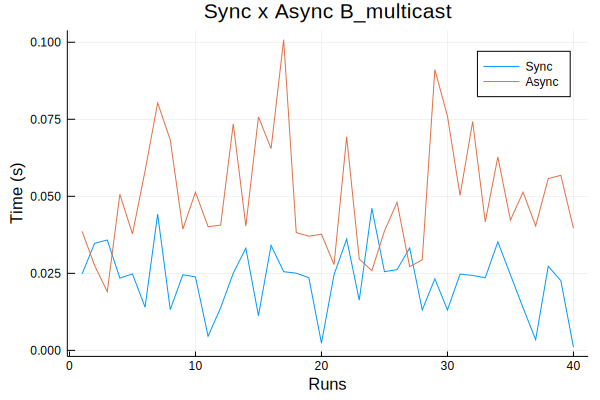

In [7]:
deleteat!(syncTimes, UnitRange(1, 10))
deleteat!(asyncTimes, UnitRange(1, 10))
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

plot(1:length(syncTimes),
         [syncTimes, asyncTimes],
         title="Sync x Async B_multicast",
         label=["Sync", "Async"],
         xlabel="Runs",
         ylabel="Time (s)")

In [8]:
# function B_multicast(g,m,B_deliver)
#    for p in g
#        remotecall(p, B_deliver, m)
#    end
# end

# Adding 3 processes (workers)
#addprocs(3)

# My group is composed by all workers
# g = workers()

# Multicasting "oi!" message to group `g` by assuming `println` as B_deliver function.
# B_multicast(g,"oi!",println)

### Exercício 1: Sincronismo (2,0 pontos)

Adicione 10 processos com o comando `addprocs` abaixo. 

_Atenção_: sua instalação local de Julia pode não conseguir adicionar 10 processos, use a [JuliaBox](https://juliabox.com).

In [9]:
# addprocs(10)

Modifique a implementação do B-multicast para utilizar communicação síncrona.

In [10]:
#TODO implementação do B-multicast síncrono.

Execute as duas versões do B-multicast (síncrona e assíncrona) e compare as saídas.

A ordem das mensagens das saídas foram as mesmas para ambas versões do B-multicast? Por quê?

**Resposta**: _em itálico_



### Exercício 2: Análise de desempenho do B-multicast (2,0 pontos)

Meça o tempo de execução duas versões do B-multicast (síncrona e assíncrona). Dica: utilize a macro `@time`.

* Execute 50 vezes essa medição e construa um gráfico em forma de barras:
	* cada barra representando cada versão do B-multicast;
	* calcule e coloque no gráfico o [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) com nível de 95%.
    
**Gráfico**: _por aqui_    
    
    
* Qual das duas versões teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 3: Análise de desempenho do R-multicast (3,0 pontos)

Implemente duas versões do algoritmo R-multicast: uma assíncrona e outra síncrona.

* R-multicast assíncrono

In [11]:
#TODO implementação do R-multicast síncrono.

* R-multicast assíncrono

In [12]:
#TODO implementação do R-multicast assíncrono.

Faça a mesma análise de desempenho para o R-multicast que você fez no Exercício 2.


**Gráfico**: _por aqui_    
    
    
* Qual das duas versões (R-multicast assíncrono e assíncrono) teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 4: Análise de desempenho: B-multicast vs. R-multicast (3,0 pontos)

Para cada uma das comparações abaixo, qual dos algoritmos teve o menor tempo de execução? Por quê?

* B-multicast assíncrono vs. R-multicast assíncrono.
    

**Resposta**: _em itálico_    
    
* B-multicast síncrono vs. R-multicast síncrono.


**Resposta**: _em itálico_

## Entrega

As respostas deverão ser entregues nos devidos campos desse arquivo, ou seja, em [Markdown](https://en.wikipedia.org/wiki/Markdown) e no formato [IJulia Notebook](https://github.com/JuliaLang/IJulia.jl).

O programa deve ser implementado na linguagem de programação **Julia**. Seu trabalho será testado na [JuliaBox](https://juliabox.com), portanto teste seu arquivo IJulia na JulizBox antes de enviá-lo.


### Forma 

O arquivo IJulia Notebook deverá ser entregue ao Professor **exclusivamente através do Google Classroom**.



A responsabilidade sobre a integridade do arquivo contendo trabalho é exclusivamente dos discentes. Serão ignorados os trabalhos cujos arquivos não conseguirem ser abertos pelo Professor.

### Prazos

O prazo de entrega sem atraso é o dia **18/11/17**.

Trabalhos entregues com atraso serão aceitos, no máximo, até o o dia **19/11/17**. Serão descontados 5% da nota obtida por dia de atraso.


## Pontuação extra

O(a) discente que realizar mais tarefas, além do que foi especificado neste trabalho, o professor atribuirá de 0,5 a 1,0 ponto extra a depender da relevância da contribuição no programa. O critério será decidido pelo professor. 

O(a) discente deve indicar qual é a tarefa executada. Por exemplo, adição de funcionalidades, armazenamento de dados em arquivo, documentação de código, comentários em inglês sem erros ortográficos, etc.


**Plágio** A nota zero será atribuída caso haja qualquer tipo de cópia parcial ou integral assim como as devidas medidas legais. Leia a [cartilha sobre plágio](http://www.noticias.uff.br/arquivos/cartilha-sobre-plagio-academico.pdf).

## Disclaimer

Esse material foi elaborado pelo [Prof. André Lage Freitas](https://sites.google.com/a/ic.ufal.br/andrelage/) e está licenciado sob a licença _GNU General Public License v3.0_.